# Train an AWD-LSTM language model

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.text import *
import os
from tqdm import tqdm_notebook

In [3]:
path = Path("artifacts")

In [4]:
import torch
torch.cuda.set_device(1)

The corpus is a subset of Taiga corpus, containing the following subcorpora (in folders of the same name):
- Arzamas
- Fontaka
- Interfax
- KP
- Lenta
- NPlus1

Each folder contains the "texts" folder, containing texts, one per file.

In [7]:
texts = list()
for root, _, files in tqdm_notebook(os.walk("corpus/extracted")):
    for file in files:
        with open(os.path.join(root, file)) as f:
            texts.append(f.read().strip())

In [9]:
sum(len(t.split()) for t in texts)

208006138

In [10]:
texts = pd.DataFrame(texts)

In [16]:
texts.shape

(1181970, 1)

In [19]:
bs = 64

RAM utilization peaks at around 40Gb

In [21]:
data = TextList.from_df(texts, 
                        processor=[TokenizeProcessor(tokenizer=Tokenizer(lang="xx")), 
                                                     NumericalizeProcessor(min_freq=2, max_vocab=60000)]).\
                random_split_by_pct(.1).\
                label_for_lm().\
                databunch(bs=bs)

In [22]:
data.show_batch()

idx,text
0,"риа xxmaj новости сообщил , что среди них не значатся йод и xxunk . \n xxmaj правительство на прошлой неделе поручило xxmaj xxunk на время приостановить продажу xxunk жидкостей с содержанием спирта более 25 % . xxmaj речь идет о xxunk , парфюмерии и xxunk средств . \n xxmaj вопрос о запрете оборота xxunk жидкостей возник после массового отравления в xxmaj иркутске « xxmaj xxunk » . xxmaj жертвами xxunk"
1,xxunk - 01 - xxunk + 03:00;;http : / / www.kp.ru / online / news / xxunk / \n xxmaj комсомольская xxunk два месяца назад молодого xxunk разыскивают в соседнем xxunk > xxup чп;;2017 - 01 - xxunk + 03:00;;http : / / www.kp.ru / online / news / xxunk / \n xxmaj комсомольская xxunk xxmaj липецке рабочего xxunk xxunk xxunk xxunk > xxmaj криминал;;2017 - 01 - xxunk +
2,"xxmaj жана xxmaj xxunk и xxmaj xxunk xxmaj xxunk , xxunk xxmaj xxunk xxmaj xxunk и xxmaj xxunk xxmaj xxunk , фотографиях xxmaj адольфа де xxmaj xxunk . xxmaj открытие выставки в музее xxunk приурочено к 50-летию кончины артиста , передает агентство xxup xxunk news . c начала 20-х годов xxmaj xxunk , звезда парижских "" xxmaj русских сезонов "" , находился под наблюдением врачей , а последние 20 лет"
3,"7 января "" xxmaj газпром "" приостановил и эти поставки , обвиняя xxmaj украину в незаконном отборе топлива и xxunk экспортных газопроводов . в свою очередь , президент xxmaj украины xxmaj виктор xxmaj ющенко потребовал от своего коллеги в xxmaj россии xxmaj дмитрия xxmaj медведева немедленно возобновить поставки . xxmaj пока этого не произошло , многие европейские страны xxunk большие объемы xxunk топлива . в некоторых странах , например в"
4,"в "" xxmaj газпроме "" пока не прокомментировали заявление иракских властей . в xxmaj ираке работает дочерняя компания газовой монополии - "" xxmaj газпром нефть "" . в 2009 году она выиграла тендер на разработку нефтяного месторождения xxmaj xxunk . xxmaj месторождение расположено на востоке xxmaj ирака . "" xxmaj газпром нефть "" является оператором проекта , компании принадлежит доля в 30 процентов . в августе 2012 года "" xxmaj"


In [24]:
data.save(path / "lm_data")

In [33]:
learn = language_model_learner(data, pretrained_model=None)

In [34]:
learn.unfreeze()

In [35]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


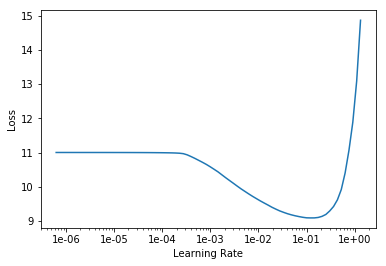

In [43]:
learn.recorder.plot()

In [40]:
from fastai.callbacks import SaveModelCallback, ReduceLROnPlateauCallback

In [45]:
learn.fit_one_cycle(5, 2e-3, moms=(0.8, 0.7), callbacks=[SaveModelCallback(learn), ReduceLROnPlateauCallback(learn, factor=0.8)])

epoch,train_loss,valid_loss,accuracy
1,3.655336,3.475370,0.390683
2,3.477082,3.311656,0.404194
3,3.415747,3.220839,0.413514
4,3.320024,3.138681,0.423168
5,3.305291,3.106956,0.427272


In [46]:
learn.save("lm_5_ep_lr2-3")

In [47]:
learn.save_encoder("lm_5_ep_lr2-3_enc")

In [320]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


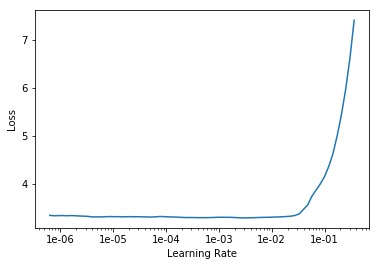

In [323]:
learn.recorder.plot()

In [324]:
learn.fit_one_cycle(5, slice(2e-3 / 20, 1e-3), moms=(0.8, 0.7), callbacks=[SaveModelCallback(learn, name="best_model_2")])

epoch,train_loss,valid_loss,accuracy
1,3.327268,3.126424,0.424546
2,3.309945,3.125146,0.424225
3,3.305685,3.107883,0.426271
4,3.311324,3.091680,0.428564
5,3.258298,3.086017,0.429533


In [325]:
learn.save("lm_5_ep_lr2-3_5_stlr")
learn.save_encoder("lm_5_ep_lr2-3_5_stlr_enc")

In [477]:
learn.predict("Россиян шокировали", 15)

'Россиян шокировали обладателями бюджетных средств . \n\n\n " xxmaj граждане не ответили и не хотели бы xxup'